In [1]:
import os
import pickle
import random
import cv2 as cv
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from IPython.display import HTML, display, Image
from tensorflow.keras import Model, layers, metrics, optimizers, callbacks

In [2]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [3]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    pooling="avg"
)
model.trainable = False
#x = layers.BatchNormalization()(model.output)
#x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = model(inputs) #layers.Dense(EMBEDDING_DIM, name="pred")(x)
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

In [4]:
model.summary()

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________


In [5]:
release = '34014'

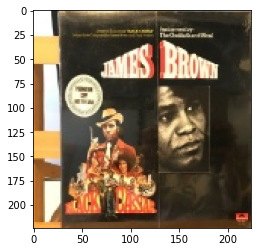

In [7]:
img = cv.imread(f'popsike/cropped_{release}.jpg', cv.IMREAD_COLOR)
img = cv.resize(img, (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_AREA)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig = plt.figure()
fig.add_subplot().imshow(img)
plt.show()

In [8]:
test_vector = model.predict(np.array([img]))

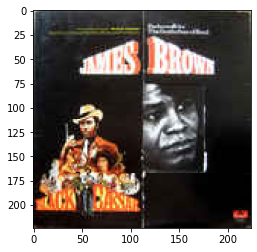

In [9]:
img = cv.imread('thumbs/thumb_' + release + '.jpg', cv.IMREAD_COLOR)
img = cv.resize(img, (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_AREA)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
fig = plt.figure()
fig.add_subplot().imshow(img)
plt.show()

In [10]:
ground_truth_vector = model.predict(np.array([img]))

In [11]:
np.linalg.norm(ground_truth_vector[0] - test_vector[0])

11.45248

### Precompute image vectors

In [11]:
batch_size = 256
image_vectors = {}

In [12]:
releases = [_[6:-4] for _ in os.listdir('thumbs') if _[6:-4].isnumeric()]

In [ ]:
for i in tqdm(range(0, len(releases), batch_size)):
    batch = []
    for j in range(0, min(batch_size, len(releases) - i)):
        img = cv.imread(f'thumbs/thumb_{releases[i + j]}.jpg', cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_AREA)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        batch += [img]
    vectors = model.predict(np.array(batch))
    for j in range(0, min(batch_size, len(releases) - i)):
        image_vectors[releases[i + j]] = vectors[j]

In [ ]:
pickle.dump(image_vectors, open('image_vectors.p', 'wb'))

In [14]:
image_vectors = pickle.load(open('image_vectors.p', 'rb'))

### Baseline model

In [263]:
distances = [(np.linalg.norm(image_vectors[_] - test_vector[0]), _) for _ in image_vectors]

In [264]:
distances.sort()

9.842921 34014


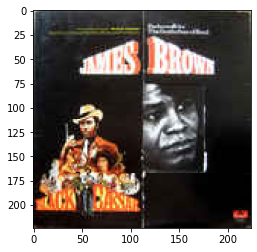

11.11848 1010058


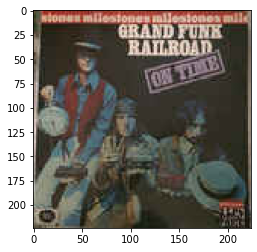

11.30015 138359


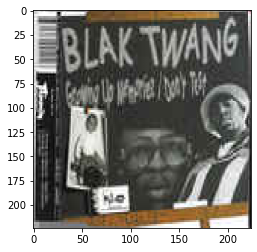

11.329363 1056417


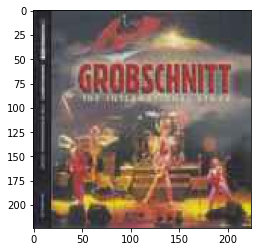

11.348825 1431183


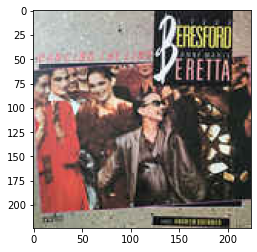

In [265]:
for _ in distances[:5]:
    print(_[0], _[1])
    img = cv.imread(f'thumbs/thumb_{_[1]}.jpg', cv.IMREAD_COLOR)
    img = cv.resize(img, (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_AREA)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    fig = plt.figure()
    fig.add_subplot().imshow(img)
    plt.show()

### Base of embedding model

In [12]:
matrix = np.array([image_vectors[_] for _ in image_vectors])
matrix.shape

(1023209, 1280)

In [21]:
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.Embedding(matrix.shape[0],
                              matrix.shape[1],
                              input_length=1,
                              weights=[matrix],
                              trainable=False))

In [13]:
release_to_index = dict([(release, index) for index, release in enumerate(image_vectors)])

In [27]:
model.predict([release_to_index[release]])

array([[[-0.01845782,  0.07095014, -0.03769805, ...,  0.7788788 ,
         -0.10673977,  0.40054533]]], dtype=float32)

In [28]:
ground_truth_vector[0]

array([-0.01845761,  0.07095054, -0.03769783, ...,  0.77888006,
       -0.10673983,  0.40054527], dtype=float32)

### Triplet loss model

In [12]:
# https://keras.io/examples/vision/siamese_network/

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [13]:
base_cnn = tf.keras.applications.EfficientNetB0(include_top=False,
                                                weights="imagenet",
                                                pooling="avg")

layer = layers.Flatten()(base_cnn.output)
layer = layers.Dense(1024)(layer)
layer = layers.LeakyReLU(0.2)(layer)
layer = layers.BatchNormalization()(layer)
layer = layers.Dropout(rate=0.5)(layer)
layer = layers.Dense(512)(layer)
output = layer

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "top_conv":
        trainable = True
    layer.trainable = trainable

In [14]:
embedding.summary()

Model: "Embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
__________________________________________________________________________________________

In [15]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=(IMG_SIZE, IMG_SIZE, 3))
positive_input = layers.Input(name="positive", shape=(IMG_SIZE, IMG_SIZE, 3))
negative_input = layers.Input(name="negative", shape=(IMG_SIZE, IMG_SIZE, 3))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [16]:
siamese_model = SiameseModel(siamese_network)

In [17]:
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

In [18]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.01),
        preprocessing.RandomTranslation(height_factor=(-.05, 0.05), width_factor=(-0.05, 0.05)),
        preprocessing.RandomZoom(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
        preprocessing.RandomContrast(factor=0.3),
    ],
    name="img_augmentation",
)

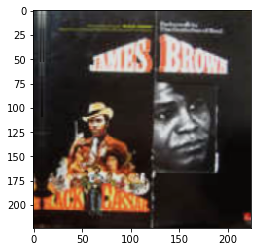

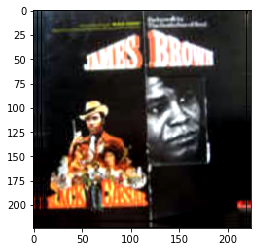

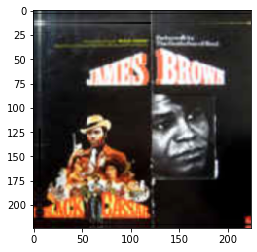

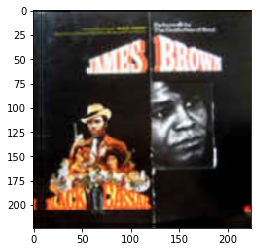

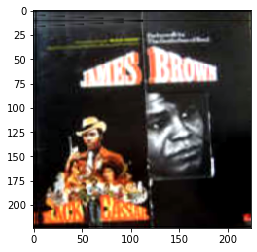

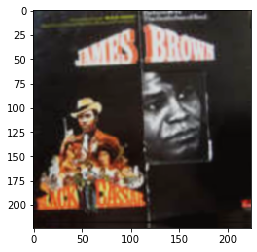

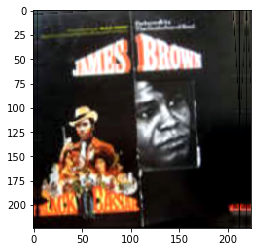

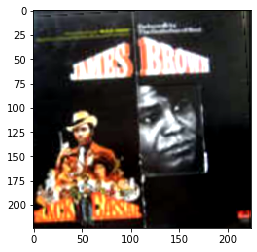

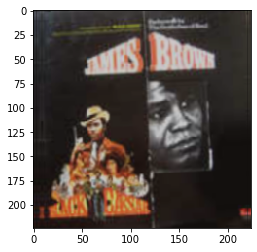

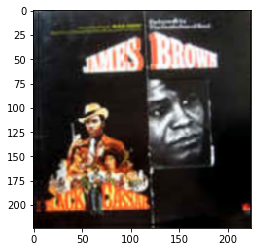

In [19]:
for _ in range(10):
    aug_img = img_augmentation(tf.expand_dims(img, axis=0))
    fig = plt.figure()
    fig.add_subplot().imshow(aug_img[0].numpy().astype("uint8"))

In [20]:
def preprocess_image(release, augment=True):
    if type(release) == int:
        release = f'thumbs/thumb_{release}.jpg'
    img = cv.imread(release, cv.IMREAD_COLOR)
    img = cv.resize(img, (IMG_SIZE, IMG_SIZE), interpolation = cv.INTER_AREA)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    if augment:
        img = img_augmentation(tf.expand_dims(img, axis=0))
        img = img[0].numpy().astype("uint8")
    return img

In [21]:
train_val_split = 0.8
releases = [_[6:-4] for _ in os.listdir('thumbs') if _[6:-4].isnumeric()]


def generator(batch_size, validation=False):
    index = 0
    indices = [int(_) for _ in releases]
    random.shuffle(indices)
    indices = indices[int(train_val_split * len(releases)
                          ):] if validation else indices[:int(train_val_split *
                                                              len(releases))]
    while True:
        anchors = []
        positives = []
        negatives = []
        for _ in range(batch_size):
            while True:
                not_index = random.randint(0, len(indices) - 1)
                if not_index != index:
                    break
            anchors += [np.array([preprocess_image(indices[index], augment=True)])]
            positives += [np.array([preprocess_image(indices[index], augment=False)])]
            negatives += [np.array([preprocess_image(indices[not_index], augment=False)])]
            index = index + 1
            if index == len(indices):
                index = 0
                random.shuffle(indices)
        yield [anchors, positives, negatives]

In [ ]:
batch_size = 1024
siamese_model.fit(generator(batch_size),
                  epochs=50,
                  steps_per_epoch=train_val_split * len(releases) / batch_size,
                  validation_data=generator(batch_size, validation=True),
                  validation_steps=(1 - train_val_split) * len(releases) /
                  batch_size,
                  callbacks=[
                      callbacks.ModelCheckpoint('discographer.h5',
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True)
                  ])

Epoch 1/50
800/799 [==============================] - ETA: -5s - loss: 1.1683

In [23]:
siamese_model.load_weights('discographer.h5')

In [44]:
embedding.save('embedding_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: embedding_model/assets


In [45]:
embedding_vectors = {}

In [46]:
for i in tqdm(range(0, len(releases), batch_size)):
    batch = []
    for j in range(0, min(batch_size, len(releases) - i)):
        batch += [preprocess_image(f'thumbs/thumb_{releases[i + j]}.jpg', augment=False)]
    vectors = embedding.predict(np.array(batch))
    for j in range(0, min(batch_size, len(releases) - i)):
        embedding_vectors[releases[i + j]] = vectors[j]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
pickle.dump(embedding_vectors, open('embedding_vectors.p', 'wb'))

In [78]:
embedding_vectors = pickle.load(open('embedding_vectors.p', 'rb'))

### Test

In [31]:
def _src_from_data(data):
    """Base64 encodes image bytes for inclusion in an HTML img element"""
    img_obj = Image(data=data)
    for bundle in img_obj._repr_mimebundle_():
        for mimetype, b64value in bundle.items():
            if mimetype.startswith('image/'):
                return f'data:{mimetype};base64,{b64value}'


def test_model(baseline=False):
    test_images = [_[8:-4] for _ in os.listdir('popsike') if 'cropped' in _]
    for test_image in test_images:
        if baseline:
            x = model.predict(
                np.array([
                    preprocess_image(f'popsike/cropped_{test_image}.jpg',
                                     augment=False)
                ]))
            y = model.predict(
                np.array([
                    preprocess_image(f'thumbs/thumb_{test_image}.jpg',
                                     augment=False)
                ]))
            distances = sorted([(np.linalg.norm(image_vectors[_] - x[0]), _)
                                for _ in image_vectors])
            distance = np.linalg.norm(y[0] - x[0])

        else:
            x = embedding.predict(
                np.array([
                    preprocess_image(f'popsike/cropped_{test_image}.jpg',
                                     augment=False)
                ]))
            y = embedding.predict(
                np.array([
                    preprocess_image(f'thumbs/thumb_{test_image}.jpg',
                                     augment=False)
                ]))
            distances = sorted([(np.dot(embedding_vectors[_], x[0]) /
                                 np.linalg.norm(embedding_vectors[_]) /
                                 np.linalg.norm(x[0]), _)
                                for _ in embedding_vectors],
                               reverse=True)
            distance = np.dot(y[0], x[0]) / np.linalg.norm(
                y[0]) / np.linalg.norm(x[0])

        src = _src_from_data(
            open('popsike/cropped_' + test_image + '.jpg', 'rb').read())
        caption = f'{test_image} ({distance})'
        figures = [(f'''
            <figure style="margin: 5px !important;">
              <img src="{src}" style="height: auto">
              {caption}
            </figure>
        ''')]
        for _ in distances[:5]:
            src = _src_from_data(
                open('thumbs/thumb_' + _[1] + '.jpg', 'rb').read())
            caption = _[1] + ' (' + str(_[0]) + ')'
            figures += [(f'''
                <figure style="margin: 5px !important;">
                  <img src="{src}" style="height: auto">
                  {caption}
                </figure>
            ''')]
        display(
            HTML(data=f'''
                <div style="display: flex; flex-flow: row wrap; text-align: center;">
                {''.join(figures)}
                </div>
            '''))


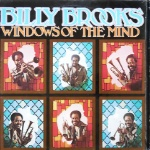
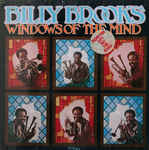
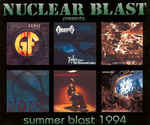
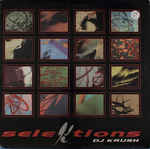
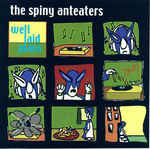
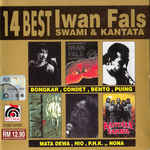


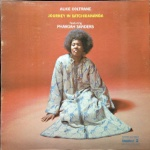
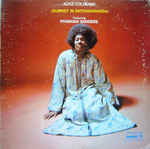
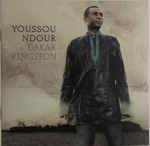
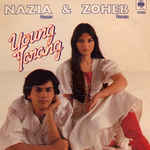
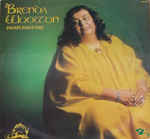
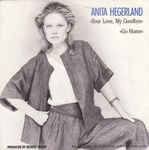


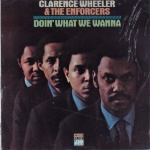
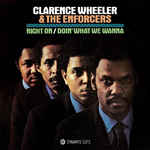
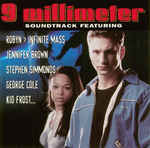
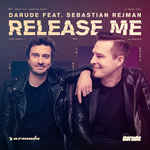
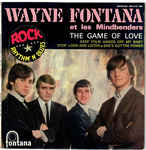
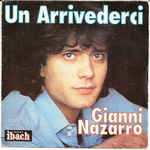


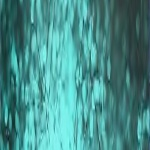
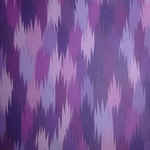
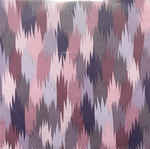
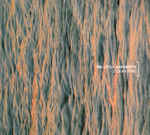
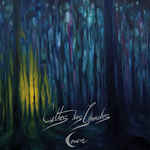
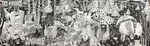


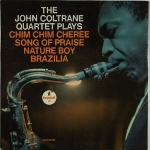
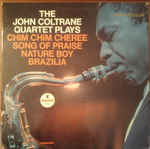
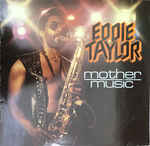
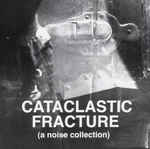
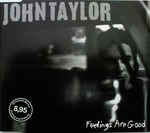
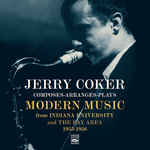


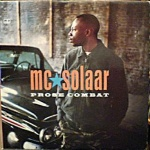
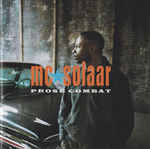
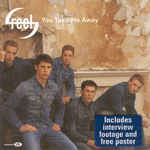
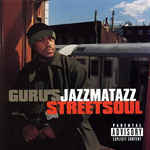
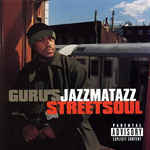
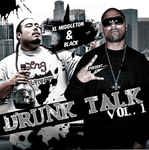


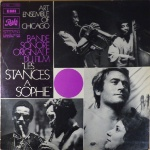
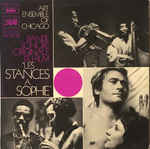
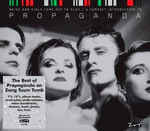
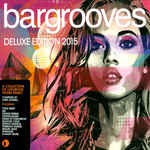
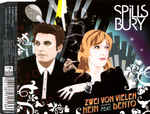
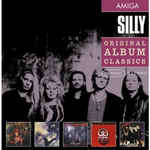


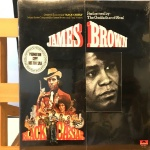
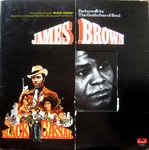
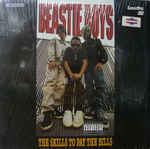
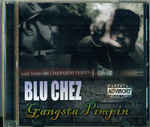
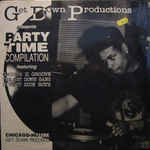
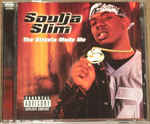


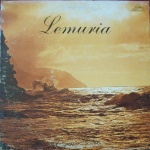
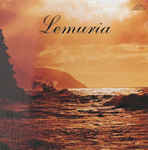
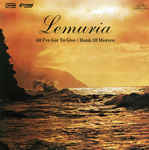
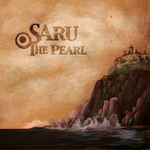
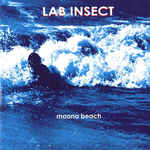
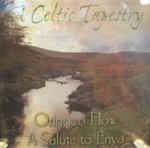


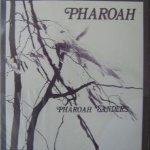
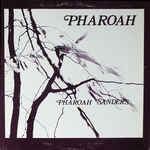
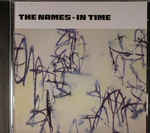
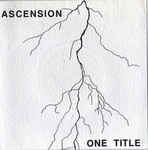
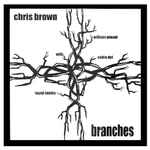
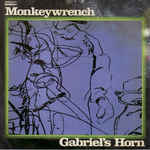


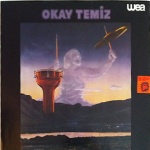
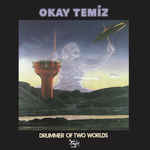
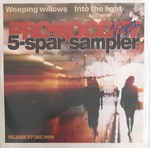
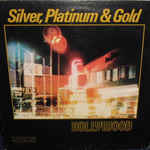
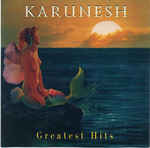
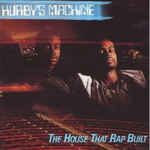


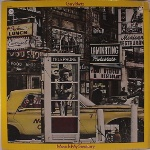
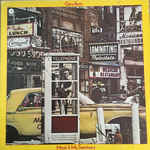
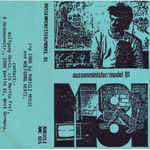
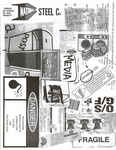
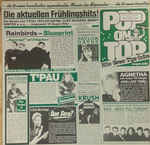
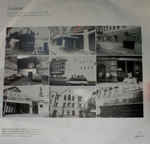


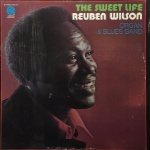
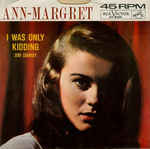
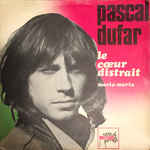
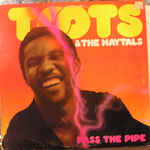
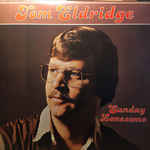
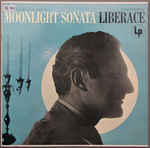


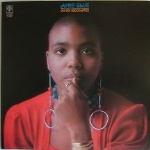
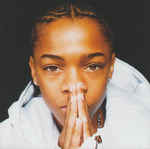
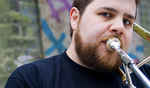
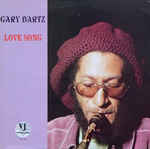
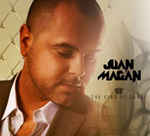
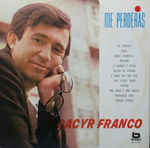

In [33]:
test_model(baseline=True)


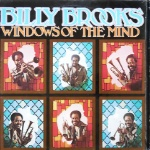
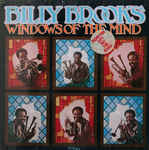
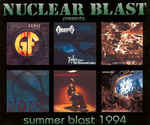
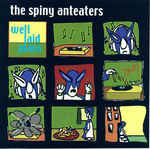
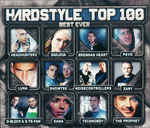
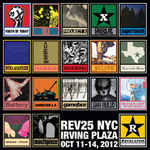


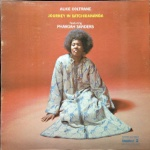
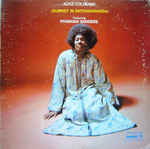
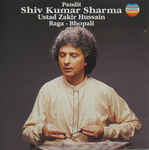
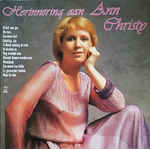
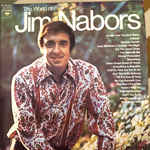
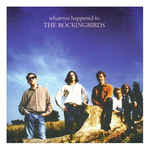


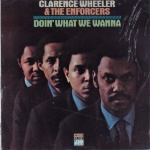
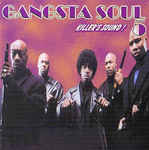
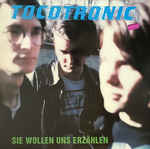
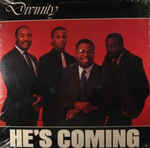
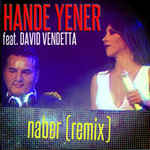
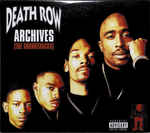


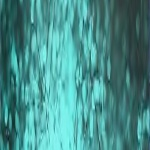
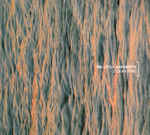
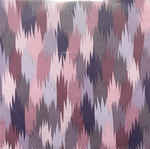
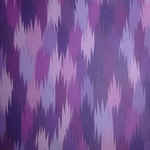
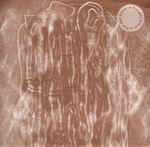
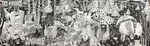


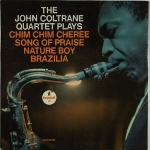
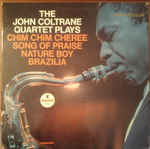
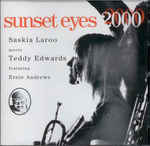
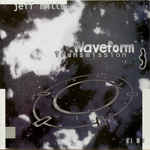
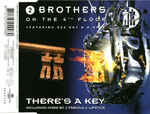
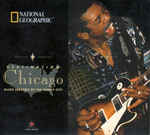


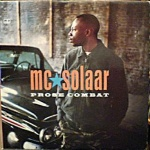
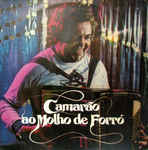
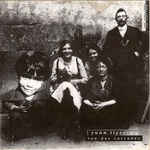
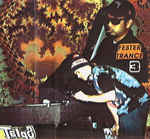
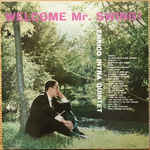
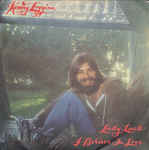


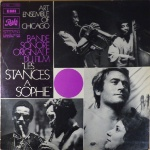
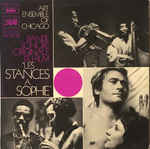
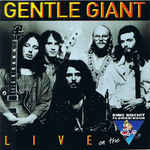
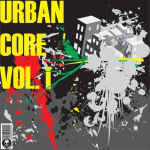
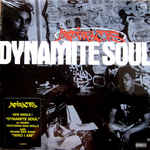
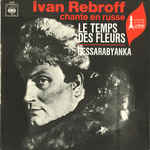


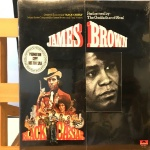
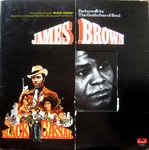
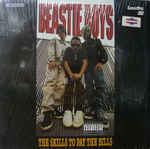
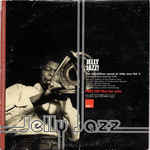
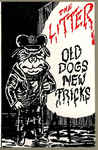
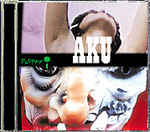


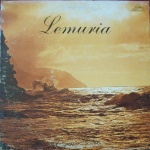
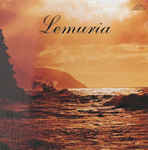
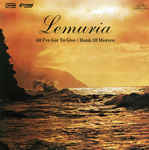
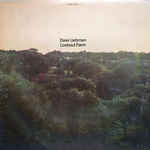
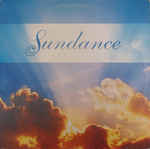
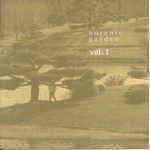


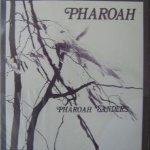
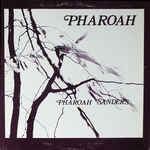
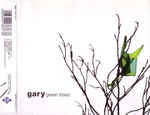
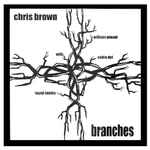
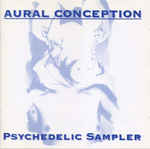
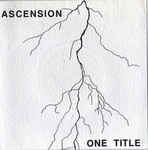


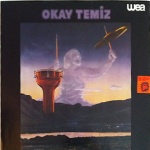
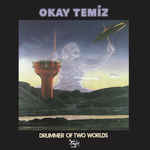
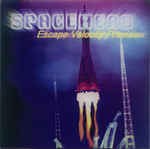
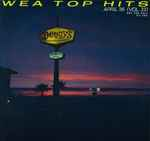
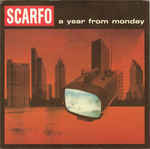
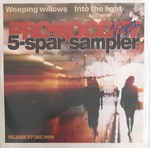


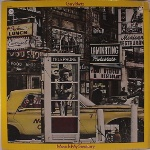
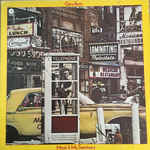
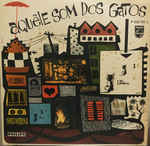
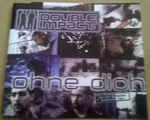
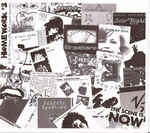
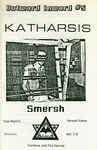


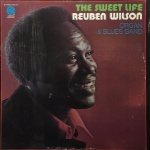
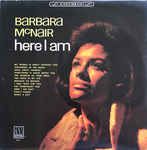
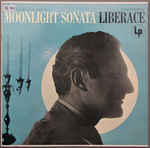
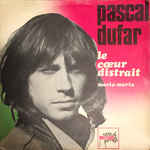
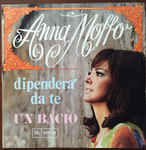
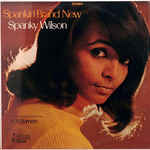


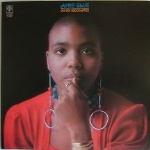
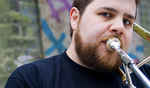
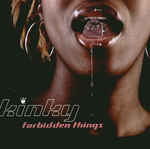
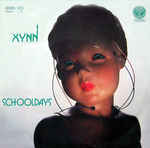
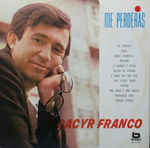
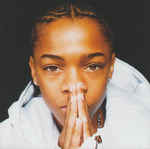

In [48]:
test_model(baseline=False)